In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import timedelta

C:\Users\amit\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\amit\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\amit\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

## Data Loading

In [3]:
def parser(s):
    return datetime.strptime(s,"%d-%m-%y")

In [4]:
fish_oil_df=pd.read_csv("Y:/Time Series/Projects/Fish oil/Global_fish_oil_quarterly.csv", parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [35]:
fish_oil_df = fish_oil_df.asfreq(pd.infer_freq(fish_oil_df.index))
fish_oil_df.head(100)

date
2021-04-01    0.612826
2021-01-01   -0.801388
2020-10-01   -1.101059
2020-07-01    0.320697
2020-04-01    0.491735
                ...   
1997-07-01   -0.109833
1997-04-01    0.000000
1997-01-01    2.031914
1996-10-01    0.213454
1996-07-01   -0.907178
Freq: -1QS-OCT, Length: 100, dtype: float64

In [6]:
def plot_series(series):
    plt.figure(figsize=(17,8))
    plt.plot(fish_oil_df, color='red')
    plt.title("Global fish oil prices in dollars per metric ton",fontsize=40)
    plt.ylabel("Quarterly prices", fontsize=25)
    for year in range(1990, 2021):
        plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.2)
    plt.axhline(0, linestyle='--', color='k', alpha=0.3)

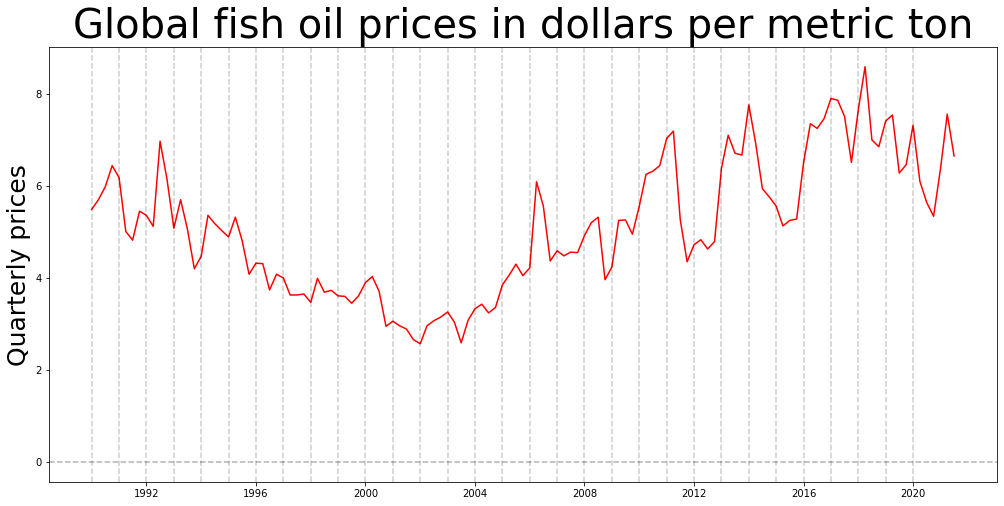

In [7]:
plot_series(fish_oil_df)

In [8]:
#Normalizing the data
avg, std= fish_oil_df.mean(), fish_oil_df.std()
fish_oil_df=fish_oil_df-avg/std

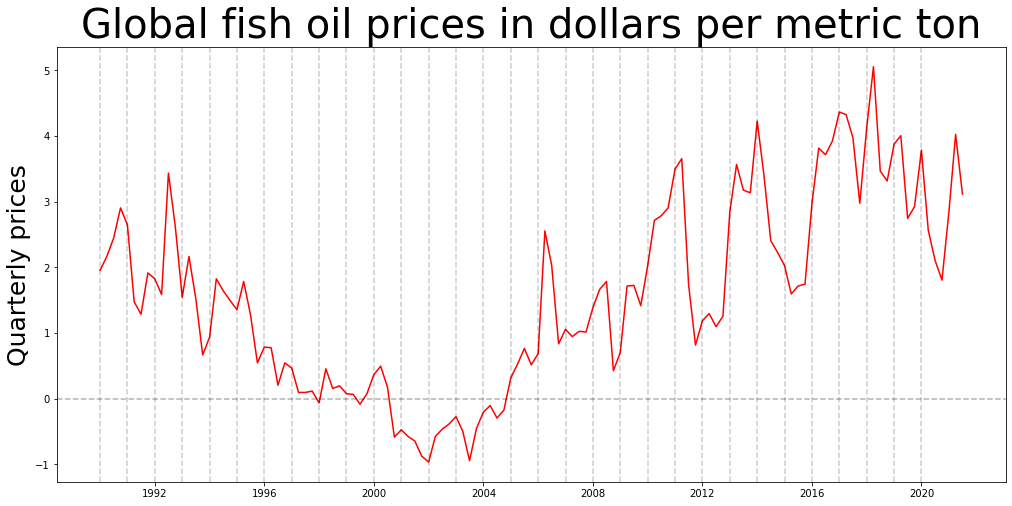

In [9]:
plot_series(fish_oil_df)

### Stationary check

In [10]:
print("Diskey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(fish_oil_df)[1])

Diskey-Fuller test: p=0.607733


### Take First Difference to Remove Trend

In [11]:
fish_oil_df = fish_oil_df.diff().dropna()

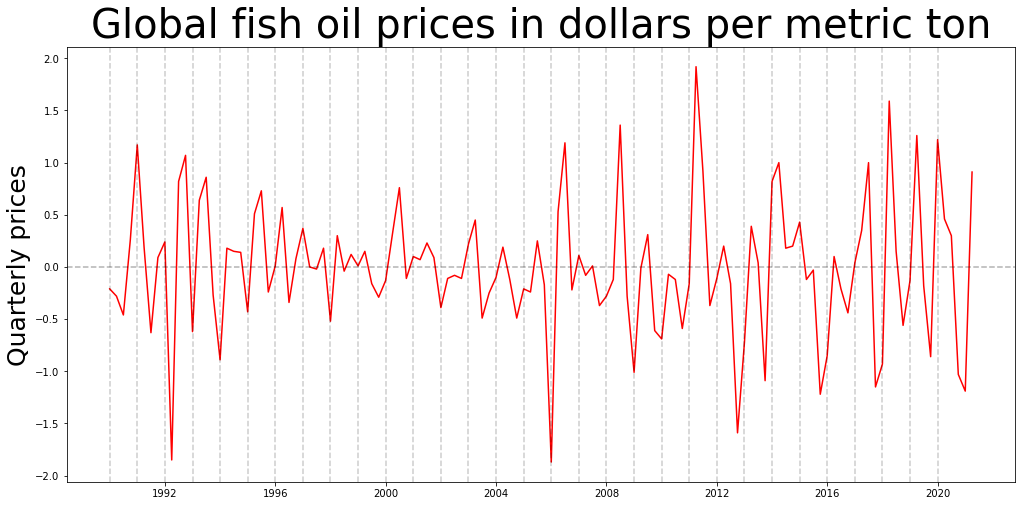

In [12]:
plot_series(fish_oil_df)

### Stationary check

In [13]:
print("Diskey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(fish_oil_df)[1])

Diskey-Fuller test: p=0.000000


### Remove Increasing Volatility

In [14]:
annual_volatility = fish_oil_df.groupby(fish_oil_df.index.year).std()

In [15]:
annual_volatility.head()

date
1990    0.306961
1991    0.739797
1992    1.326374
1993    0.710276
1994    0.523609
Name: price, dtype: float64

In [16]:
fish_oil_annual_vol = fish_oil_df.index.map(lambda d: annual_volatility.loc[d.year])

In [17]:
fish_oil_df = fish_oil_df/fish_oil_annual_vol

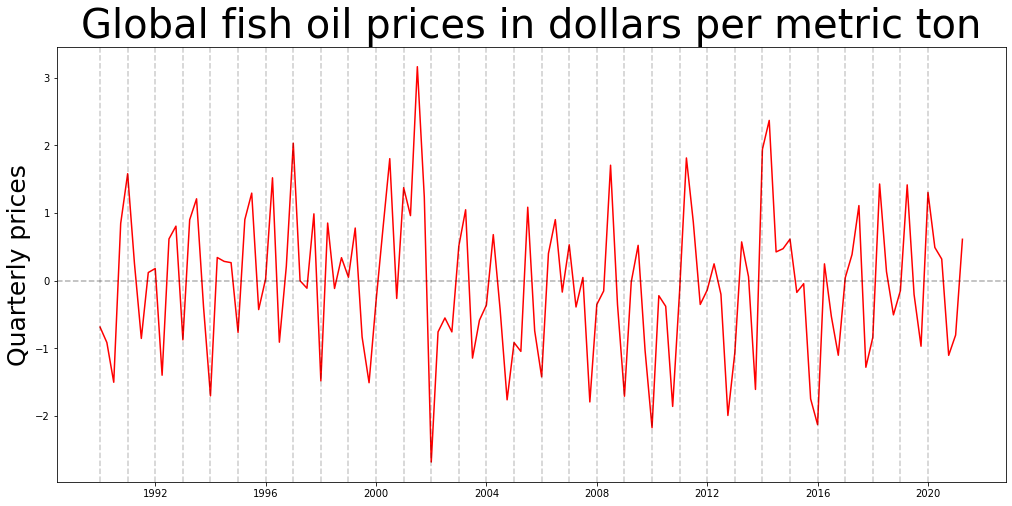

In [18]:
plot_series(fish_oil_df)

### Stationary check

In [19]:
print("Diskey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(fish_oil_df)[1])

Diskey-Fuller test: p=0.000000


### ACF and PACF

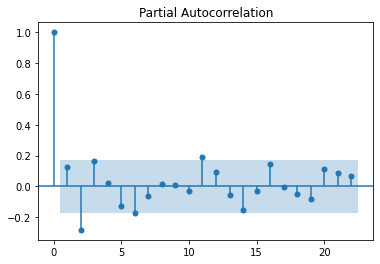

In [20]:
plot_pacf(fish_oil_df)
plt.show()

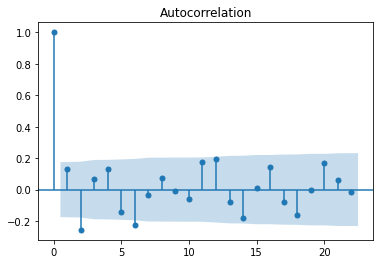

In [21]:
plot_acf(fish_oil_df)
plt.show()

### Get training and testing sets

In [22]:
train_end = datetime(2015,1,1)
test_end = datetime(2021,7,1)

train_data = fish_oil_df[train_end:]
test_data = fish_oil_df[:train_end + timedelta(days=1)]

In [23]:
test_data.head()

date
2021-04-01    0.612826
2021-01-01   -0.801388
2020-10-01   -1.101059
2020-07-01    0.320697
2020-04-01    0.491735
Freq: -1QS-OCT, dtype: float64

In [24]:
#create the model
model = ARMA(fish_oil_df, order=(2,2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


In [25]:
model_fit=model.fit()

In [26]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  126
Model:                     ARMA(2, 2)   Log Likelihood                -177.492
Method:                       css-mle   S.D. of innovations              0.989
Date:                Tue, 26 Jul 2022   AIC                            366.984
Time:                        14:49:39   BIC                            384.001
Sample:                             0   HQIC                           373.897
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0447      0.088     -0.510      0.610      -0.216       0.127
ar.L1.y       -0.3046      0.253     -1.203      0.229      -0.801       0.192
ar.L2.y       -0.4897      0.202     -2.427      0.0

In [27]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [28]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

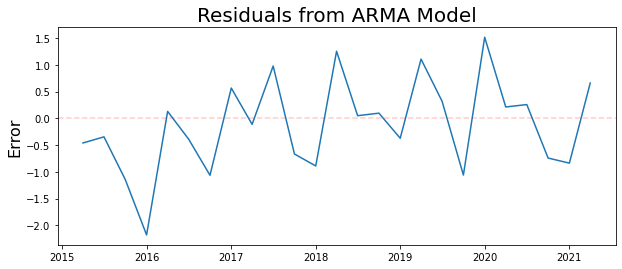

In [29]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from ARMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Quarterly prices')

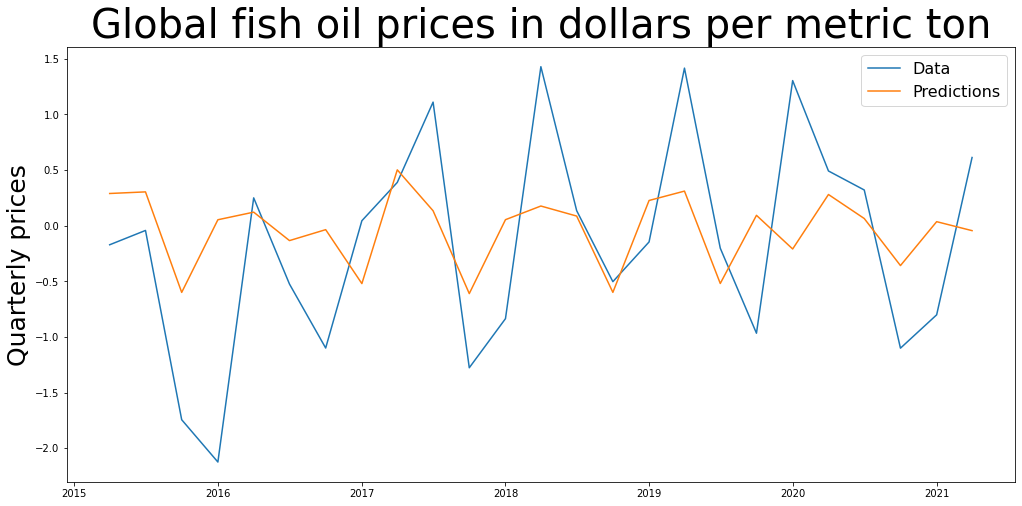

In [33]:
plt.figure(figsize=(17,8))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title("Global fish oil prices in dollars per metric ton",fontsize=40)
plt.ylabel("Quarterly prices", fontsize=25)

In [31]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.8592912075608385
